In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt  # Import for plotting

In [2]:
# Data loader function
def dataloader(train_dataset, test_dataset):

    # Set the length of the batch (number of samples per batch)
    batch_size = 50

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=len(test_dataset),
        shuffle=True
    )
    print(f'Training has {len(train_loader)} batches of data!')
    print(f'Testing has {len(test_loader)} batches of data!')
    return train_loader, test_loader

In [3]:
# Data loading function
def load_data(dataset_name='MNIST'):
    if dataset_name == 'MNIST':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))  # Single channel normalization for MNIST
        ])

        # Load MNIST dataset
        train_dataset = torchvision.datasets.MNIST(
            root="./data/mnist",
            train=True,
            download=True,
            transform=transform
        )

        test_dataset = torchvision.datasets.MNIST(
            root="./data/mnist",
            train=False,
            download=True,
            transform=transform
        )

    elif dataset_name == 'CIFAR10':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 3 channel normalization for CIFAR-10
        ])

        # Load CIFAR-10 dataset
        train_dataset = torchvision.datasets.CIFAR10(
            root="./data/cifar10",
            train=True,
            download=True,
            transform=transform
        )

        test_dataset = torchvision.datasets.CIFAR10(
            root="./data/cifar10",
            train=False,
            download=True,
            transform=transform
        )
    else:
        raise ValueError("Unsupported dataset. Choose either 'MNIST' or 'CIFAR10'.")

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=50,
        shuffle=True
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=50,
        shuffle=False
    )

    print(f"The number of training data: {len(train_dataset)}")
    print(f"The number of testing data: {len(test_dataset)}")
    print(f"Training has {len(train_loader)} batches of data!")
    print(f"Testing has {len(test_loader)} batches of data!")
    return train_loader, test_loader, train_dataset, test_dataset

In [4]:
# Define the ConvNet class
class ConvNet(nn.Module):
    def __init__(self, input_channels=1):
        super(ConvNet, self).__init__()

        # First Convolutional Layer
        self.conv1 = nn.Conv2d(input_channels, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        # Third Convolutional Layer
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        # Fourth Convolutional Layer
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        # Maxpool layer
        self.pool = nn.MaxPool2d(2, 2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(512 * 1 * 1, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 10)

        # Dropout layer
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # Apply the convolutional layers with LeakyReLU activations
        x = self.pool(nn.functional.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.1))
        x = self.pool(nn.functional.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.1))
        x = self.pool(nn.functional.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.1))
        x = self.pool(nn.functional.leaky_relu(self.bn4(self.conv4(x)), negative_slope=0.1))

        # Flatten the tensor before passing it to the fully connected layers
        x = x.view(-1, 512 * 1 * 1)

        # Fully connected layers with Dropout
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = nn.functional.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

In [5]:
# Training function
def train(model, train_loader, optimizer, lossFun, device):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(features)
        loss = lossFun(preds, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(preds, 1)
        running_acc += (predicted == labels).sum().item() / labels.size(0)

    avg_loss = running_loss / len(train_loader)
    avg_acc = running_acc / len(train_loader)
    return avg_loss, avg_acc

In [6]:
# Validation function
def validate(model, test_loader, device):
    model.eval()
    val_accuracy = 0.0
    num_correct = 0
    num_samples = 0

    with torch.no_grad():
        for val_features, val_labels in test_loader:
            val_features, val_labels = val_features.to(device), val_labels.to(device)
            val_preds = model(val_features)
            _, val_predicted = torch.max(val_preds, axis=1)
            num_correct += (val_predicted == val_labels).sum().item()
            num_samples += len(val_labels)

    val_accuracy = num_correct / num_samples
    return val_accuracy

In [7]:
# Plotting function
def plot_accuracies(train_accuracies, val_accuracies):
    epochs = range(1, len(train_accuracies) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracies, label='Training Accuracy', color='blue', marker='o')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='green', marker='o')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 53.7MB/s]


Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.67MB/s]

Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 7.82MB/s]


Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.04MB/s]

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



The number of training data: 60000
The number of testing data: 10000
Training has 1200 batches of data!
Testing has 200 batches of data!
Epoch [1/10] - Loss: 0.1241, Accuracy: 96.2033%
Validation Accuracy: 98.3500%
Best model saved with accuracy: 98.3500%
Epoch [2/10] - Loss: 0.0503, Accuracy: 98.6267%
Validation Accuracy: 99.0300%
Best model saved with accuracy: 99.0300%
Epoch [3/10] - Loss: 0.0359, Accuracy: 98.9717%
Validation Accuracy: 99.1300%
Best model saved with accuracy: 99.1300%
Epoch [4/10] - Loss: 0.0294, Accuracy: 99.1883%
Validation Accuracy: 99.1000%
Epoch [5/10] - Loss: 0.0256, Accuracy: 99.3050%
Validation Accuracy: 99.0400%
Epoch [6/10] - Loss: 0.0232, Accuracy: 99.3867%
Validation Accuracy: 99.3100%
Best model saved with accuracy: 99.3100%
Epoch [7/10] - Loss: 0.0187, Accuracy: 99.5200%
Validation Accuracy: 99.0200%
Epoch [8/10] - Loss: 0.0189, Accuracy: 99.5017%
Validation Accuracy: 99.1000%
Epoch [9/10] - Loss: 0.0167, Accuracy: 99.5850%
Validation Accuracy: 98.960

<ipython-input-8-e1b931cfc713>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Test Accuracy: 99.3100%


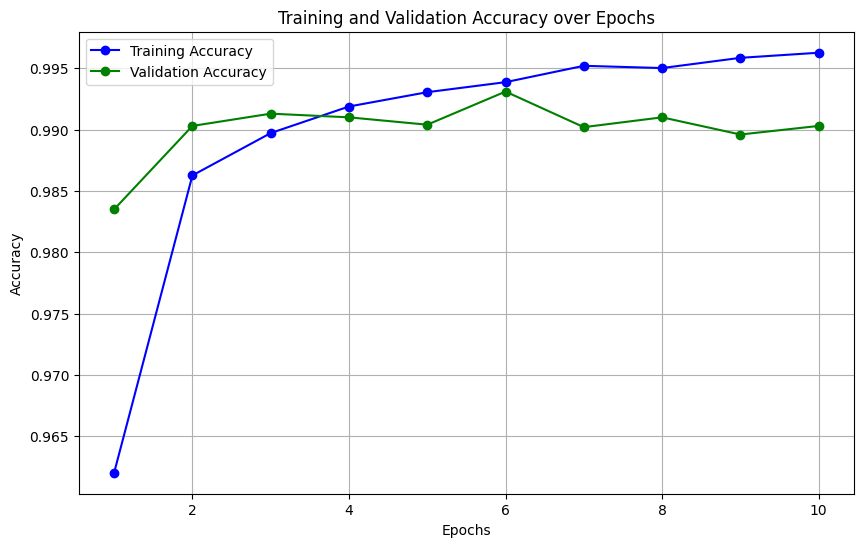

In [8]:
# Main function
def main(dataset_name='MNIST'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    learning_rate = 0.0005
    epoches = 10
    best_model_path = 'best_model.pth'

    # Load data
    train_loader, test_loader, train_dataset, test_dataset = load_data(dataset_name)

    # Set input channels based on dataset
    input_channels = 1 if dataset_name == 'MNIST' else 3
    model = ConvNet(input_channels=input_channels).to(device)
    lossFun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_accuracy = 0.0

    # Track accuracy values for plotting
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epoches):
        # Training
        train_loss, train_acc = train(model, train_loader, optimizer, lossFun, device)
        train_accuracies.append(train_acc)  # Store training accuracy
        print(f"Epoch [{epoch+1}/{epoches}] - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4%}")

        # Validation
        val_accuracy = validate(model, test_loader, device)
        val_accuracies.append(val_accuracy)  # Store validation accuracy
        print(f"Validation Accuracy: {val_accuracy:.4%}")

        # Save the best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved with accuracy: {best_accuracy:.4%}")

    # Test the model
    model.load_state_dict(torch.load(best_model_path))
    test_accuracy = validate(model, test_loader, device)
    print(f"Test Accuracy: {test_accuracy:.4%}")

    # Plot the accuracies
    plot_accuracies(train_accuracies, val_accuracies)

# Run the main function
if __name__ == '__main__':
    main('MNIST')  # or main('CIFAR10')